In [1]:
import sys
sys.path.insert(0, '/home/jonathan/Documents/mi3-balance/build/python')
import drjit as dr
import mitsuba as mi
from drjit.auto import Float, UInt
mi.set_variant('cuda_ad_rgb')

In [2]:
import numpy as np

SPP = 64
center = np.zeros(3)
radius = 1.0
emitter_intensity = 1.0
color_ref = [0.2, 0.25, 0.7]

In [3]:
import gpytoolbox as gp
import polyscope as ps

def visualize_scene(sph_center, sph_radius, emitter_center, probe_origins, probe_directions):
    V, F = gp.icosphere(n=4)

    ps.init()

    # show geo
    ps.register_surface_mesh("Sphere", V * sph_radius + sph_center[None,:], F)

    # show emitters
    # ps.register_surface_mesh("Emitter", V * 0.01 + emitter_center[None,:], F, color=[1,1,0])
    ps.register_point_cloud("Emitter", emitter_center[None,:], color=[1,1,0])

    # show probes
    probes = ps.register_point_cloud("Probes", probe_origins)
    probes.add_vector_quantity("LookAt", probe_directions)
    ps.show()

In [4]:


def make_sphere(center, radius, color_ref):
    geo_dict = {
        "type": "sphere",
        "center": [center[0], center[1], center[2]],
        "radius": radius,
        "flip_normals": True,
        "bsdf": {
            "type": "diffuse",
            "reflectance": {
                "type": "rgb",
                "value": color_ref
            }
        }
    }
    return geo_dict

def make_emitter(center, emitter_intensity):
    emitter_dict = {
        "type": "point",
        "position": [center[0], center[1], center[2] + 0.1],
        "intensity": {
            "type": "uniform",
            "value": emitter_intensity,
        }
    }
    return emitter_dict

def make_probes(origins: np.ndarray, directions: np.ndarray):
    probes = {
        "type": "batch",
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "box" },
                "width": NUM_PROBES,
                "height": 1,
            },
            "sampler": {
                "type": "independent",
                "sample_count": SPP,
            }
    }

    for idx, (origin, direction) in enumerate(zip(origins, directions)):
        sensor_name = f"sensor{idx}"
        probe = {
            "type": "radiancemeter",
            "origin": [origin[0], origin[1], origin[2]],
            "direction": [direction[0], direction[1], direction[2]],
            "film": {
                "type": "hdrfilm",
                "pixel_format": "rgb",
                "rfilter": { "type": "box" },
                "width": 1,
                "height": 1,
            },
            # "sampler": {
            #     "type": "independent",
            #     "sample_count": NUM_SAMPLES,
            # }
        }
        probes[sensor_name] = probe

    return probes

    # probes = {
    #     'type': 'perspective',
    #     'fov': 45,
    #     'to_world': mi.ScalarTransform4f().look_at(
    #         origin=[0, 0, 0],
    #         target=[0, 0, 1],
    #         up=[0, 1, 0]
    #     ),
    #     "film": {
    #         "type": "hdrfilm",
    #         "filter": { "type": "box" },
    #         "width": 256,
    #         "height": 256,
    #     },
    #     "sampler": {
    #         "type": "independent",
    #         "sample_count": SPP,
    #     }
    # }

    # return probes


NUM_PROBES = 1
ts = np.linspace(0, 2 * np.pi, NUM_PROBES)
origins = np.c_[np.cos(ts), np.sin(ts), np.zeros_like(ts)] * radius
origins *= 0.95     # TODO
directions = center[None,:] - origins
directions /= np.linalg.norm(directions, axis=1)[:,None]
# origins *= 0.0 # TODO

scene_dict = {
    "type": "scene",
    "myintegrator": {
        "type": "path",
        "max_depth": 5
    },
    "mysphere": make_sphere(center, radius, color_ref),
    "myemitter": make_emitter(center, emitter_intensity),
    "mysensor": make_probes(origins, directions),

    # "emitter2": {
    #     'type': 'sphere',
    #     'radius': 0.01,
    #     'emitter': {
    #         'type': 'area',
    #         'radiance': {
    #             'type': 'rgb',
    #             'value': 10000.0,
    #         }
    #     }
    # }
}

# visualize_scene(center, radius, center, origins, directions)

In [5]:
scene = mi.load_dict(scene_dict)

[[[0, 0, 0]]]


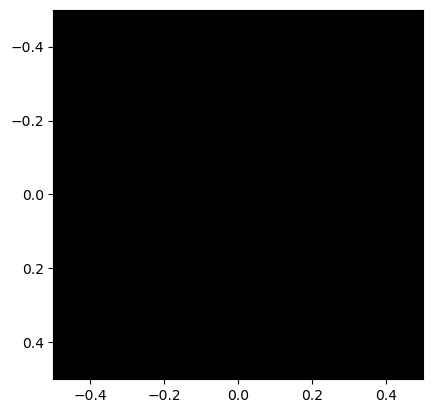

In [6]:
image = mi.render(scene)
print(image)

import matplotlib.pyplot as plt
plt.imshow(image)

In [7]:
# radiance = 10.0
# spp = 5

# scene_dict = {
#     'type': 'scene',
#     'integrator': {
#         'type': 'path'
#     },
#     'sensor': {
#         'type': 'radiancemeter',
#         'film': {
#             'type': 'hdrfilm',
#             'width': 1,
#             'height': 1,
#             'pixel_format': 'rgb',
#             'rfilter': {
#                 'type': 'box'
#             }
#         },
#         'sampler': {
#             'type': 'independent',
#             'sample_count': spp
#         }
#     },
#     'emitter': {
#         'type': 'constant',
#         'radiance': {
#             'type': 'uniform',
#             'value': radiance
#         }
#     }
# }

# scene = mi.load_dict(scene_dict)
# img = mi.render(scene)
# img

In [8]:
class SceneSurfaceSampler:
    def __init__(self, scene: mi.Scene):
        shape_ptrs = scene.shapes_dr()
        # TODO: can't figure out how to concatenate the areas (== dr.Float of size [1,])
        areas = [shape.surface_area().numpy().item() for shape in shape_ptrs]
        areas_dr = Float(areas)
        self.distribution = mi.DiscreteDistribution(areas_dr)
        self.shape_ptrs = shape_ptrs

        # self.debug_shape = scene.shapes()[0]

    def sample(self, sampler: mi.Sampler) -> mi.SurfaceInteraction3f:
        idx = self.distribution.sample(sampler.next_1d(), True)
        shape = dr.gather(mi.ShapePtr, self.shape_ptrs, idx)
        si = shape.eval_parameterization(sampler.next_2d(), active=True)
        return si

        # return self.debug_shape.eval_parameterization(sampler.next_2d(), active=True)

In [9]:
@dr.syntax
def query_radiance_cache_Li(scene: mi.Scene, sampler: mi.Sampler, si_A: mi.SurfaceInteraction3f, samples_per_direction: int):
    with dr.suspend_grad():
        # Assume that we vectorize over many `wi`.
        # Define `wi` as pointing outwards and away from `si.p` (== A). From A, we do a pathtrace
        # in the direction `wi` to get the *incoming* radiance along `-wi`
        # wi_ray = mi.Ray3f(si.p, si.to_world(wi_local))

        wi_local = mi.warp.square_to_cosine_hemisphere(sampler.next_2d())
        wi_world = si_A.to_world(wi_local)
        wi_ray = si_A.spawn_ray(wi_world)
        
        # Compute Li for each of the `N` incident directions
        Li = dr.zeros(mi.Color3f, wi_local.shape[1])

        i = UInt(0)
        while i < samples_per_direction:
            color, _, _ = scene.integrator().sample(scene, sampler, wi_ray)
            Li += color
            i += 1

        return Li / samples_per_direction, wi_local

@dr.syntax
def query_radiance_cache_Lo(scene: mi.Scene, sampler: mi.Sampler, si: mi.SurfaceInteraction3f, samples_per_direction: int):
    with dr.suspend_grad():
        # Compute the outgoing radiance from `A` for a single direction, `wo`.
        # Note that `wo` is stored in the `si.wi` field (unintuitive, but needed for BSDF.eval())
        wo = si.to_world(si.wi)
        ray = si.spawn_ray(wo)
        # invert the ray direction so that we're looking at point `A`
        ray.d = -ray.d
        
        # Pathtrace along `-wo` to get the radiance when looking at `A`
        Lo = dr.zeros(mi.Color3f)

        i = UInt(0)
        while i < samples_per_direction:
            color, _, _ = scene.integrator().sample(scene, sampler, ray)
            Lo += color
            i += 1
        return Lo / samples_per_direction

In [10]:
import time

In [11]:
from drjit.auto import PCG32

rng = PCG32()
rng.next_float32()

[0.108379]

In [12]:
NUM_WI_DIRECTIONS = 32
SAMPLES_PER_RAY_LI = 16
SAMPLES_PER_RAY_LO = 8
NUM_GEO_SAMPLES = 4

scene_sampler = SceneSurfaceSampler(scene)

def compute_loss_at_surface_pos(si: mi.SurfaceInteraction3f, trainable_bsdf: mi.BSDF, scalar_sampler: mi.Sampler, wide_sampler: mi.Sampler) -> Float:
    with dr.suspend_grad():
        # LHS: compute Lo
        lhs = query_radiance_cache_Lo(scene, scalar_sampler, si, SAMPLES_PER_RAY_LO)
        lhs *= si.bsdf().eval_diffuse_reflectance(si, True) # TODO: why is there this missing factor, where does it come from?

        # RHS: compute the BSDF integral
        Li, wi_local = query_radiance_cache_Li(scene, wide_sampler, si, SAMPLES_PER_RAY_LI) # wide Li

    f_io, pdf = trainable_bsdf.eval_pdf(
                    mi.BSDFContext(
                        mi.TransportMode.Radiance, 
                        mi.BSDFFlags.All), 
                    si = si, wo = wi_local)                 # wide BSDF
    rhs = dr.mean(f_io * Li * dr.rcp(pdf), axis=1)
    # print(rhs, lhs)
    # # # Add Le term
    # # rhs += Le
    return 0.5 * dr.norm(rhs - lhs) ** 2

def compute_loss(scene_sampler: SceneSurfaceSampler, trainable_bsdf: mi.BSDF, scalar_sampler: mi.Sampler, wide_sampler: mi.Sampler, num_points: int):
    loss = dr.zeros(Float)
    for _ in range(num_points):
        # scalar `si` at A
        si = scene_sampler.sample(scalar_sampler)
        # scalar wo
        wo_local = mi.warp.square_to_cosine_hemisphere(scalar_sampler.next_2d())
        si.wi = wo_local
        loss += compute_loss_at_surface_pos(si, trainable_bsdf, scalar_sampler, wide_sampler)
    return loss / num_points

    # i = UInt(0)
    # while i < NUM_GEO_SAMPLES:
    #     loss += compute_loss_at_geo_point(scene_sampler, trainable_bsdf) / NUM_GEO_SAMPLES
    #     i += 1
    # return loss


# Initialize BSDF to train
bsdf_train = mi.load_dict({
    "type": "diffuse",
    "reflectance": {
        "type": "rgb",
        "value": [0.5, 0.5, 0.5] #[0.2, 0.25, 0.7]
    }
})

params = mi.traverse(bsdf_train)
opt = mi.ad.Adam(lr=0.05)
key = "reflectance.value"
dr.enable_grad(params[key])
opt[key] = params[key]
params.update(opt)

# compute_loss(scene_sampler, bsdf_train)

# losses = []
for it in range(100):

    if True: ## Temp workaround
        # Initialize samplers
        scalar_sampler = mi.load_dict({
                    'type': 'independent',
                    'sample_count': 1
                })
        scalar_sampler.seed(it, 1)

        wide_sampler = mi.load_dict({
                    'type': 'independent',
                    'sample_count': NUM_WI_DIRECTIONS
                })
        wide_sampler.seed(it, wavefront_size = NUM_WI_DIRECTIONS)


    time1 = time.time()

    # dr.set_log_level(dr.LogLevel.Info)  #

    # Evaluate the objective function for the current BSDF params
    loss = compute_loss(scene_sampler, bsdf_train, scalar_sampler, wide_sampler, NUM_GEO_SAMPLES)

    # wide_sampler.schedule_state()
    # scalar_sampler.schedule_state()

    # Backpropagate through the rendering process
    dr.backward(loss)

    # dr.eval()  #
    # dr.set_log_level(dr.LogLevel.Warn)  #


    # Optimizer: take a gradient descent step
    opt.step()

    # Post-process the optimized parameters to ensure legal color values.
    opt[key] = dr.clip(opt[key], 0.0, 1.0)

    # Update the scene state to the new optimized values
    params.update(opt)

    # losses.append(dr.detach(loss))
    time2 = time.time()
    print(f"Iteration {1+it:03d} [{time2 - time1:2f}]: Loss = {loss}, p = {opt[key]}")

Iteration 001 [6.119080]: Loss = [0.00835919], p = [[0.450009, 0.450006, 0.55]]
Iteration 002 [0.082894]: Loss = [0.00418268], p = [[0.400303, 0.400359, 0.598541]]
Iteration 003 [0.073272]: Loss = [0.00207146], p = [[0.35139, 0.351838, 0.645201]]
Iteration 004 [0.080768]: Loss = [0.000495101], p = [[0.30374, 0.305086, 0.686815]]
Iteration 005 [0.073200]: Loss = [0.000259308], p = [[0.258623, 0.262278, 0.723785]]
Iteration 006 [0.072996]: Loss = [0.000454314], p = [[0.216377, 0.223852, 0.752019]]
Iteration 007 [0.072623]: Loss = [0.000306017], p = [[0.179034, 0.19306, 0.773612]]
Iteration 008 [0.073199]: Loss = [0.0017004], p = [[0.146485, 0.168835, 0.783526]]
Iteration 009 [0.073136]: Loss = [0.00151335], p = [[0.120344, 0.152866, 0.785309]]
Iteration 010 [0.073862]: Loss = [0.00164923], p = [[0.101075, 0.144768, 0.779674]]
Iteration 011 [0.072773]: Loss = [0.00153076], p = [[0.0889745, 0.144027, 0.768933]]
Iteration 012 [0.072603]: Loss = [0.00174355], p = [[0.0829472, 0.148545, 0.752

In [13]:
# plt.plot(losses)

In [14]:
print(bsdf_train)
print(color_ref)

SmoothDiffuse[
  reflectance = SRGBReflectanceSpectrum[
    value = [[0.212001, 0.264782, 0.724778]]
  ]
]
[0.2, 0.25, 0.7]


In [15]:
# def Li_estimate(p, d):
#     # FURNACE CASE
#     # # trace a ray to the `incident` point, B
#     # ray_dir = si.to_world(-wi)
#     # vis_ray = mi.Ray3f(si.p, ray_dir)
#     # si_B = scene.ray_intersect(vis_ray, True)

#     # # At B, ...
#     # ...
#     ray = mi.Ray3f(p, d)
#     si_B = scene.ray_intersect(ray, ...)
    
#     ds_em, emitter_val = scene.sample_emitter_direction(
#             si_B, sampler.next_2d(), test_visibility=True, active=active)

#     wo = si_B.to_local(ds_em.d)
#     bsdf_val, bsdf_pdf = bsdf_ref.eval_pdf(bsdf_ctx, si_B, wo, active_em)       # compute Li using the true scene. Here, a 3-vertex path is used (A -> B -> emitter) instead of full pathtracing
#     return *

# trained_bsdf = new_BSDF(params_init=1.0)    # contains `learnable_params`


# for it in range(100):
#     uv = sample_2()
#     shape = scene...
#     si_A = shape.eval_parameterization(uv)  # pick an `A` point on the sphere

#     # sample `wo` at `A`
#     wo_world = warp_direction(sampler.next_2d())
#     L_hat = 0

#     # compute Li-BSDF convolution integral using MC
#     for k in range(16):
#         wi_local = si_A.bsdf.sample(wo)
#         Li = Li_estimate(si_A.p, -wi_local)

#         L_hat += L_i * trained_bsdf.at(si_A).eval()
    
#     loss = 0.5 * diff(L_hat, L_ref_wo) ** 2    # Lo_at_A should be the true scene's Lo as well. Use a high quality estimate

#     loss.backward()                             # propagate gradient back onto trained_BSDF's `learnable_params`
#     optimizer.step()